<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Principal Component Analysis

_Authors: Justin Pounders, Matt Brems, Noelle Brown_

### LEARNING OBJECTIVES
By the end of the lesson, students should be able to:
1. Differentiate between feature selection and feature extraction.
2. Describe the PCA algorithm.
3. Implement PCA in `scikit-learn`.
4. Calculate and interpret proportion of explained variance.
5. Identify use cases for PCA.

In [60]:
# Import our libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import from sklearn.
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

# Set a random seed.
np.random.seed(42)

### Introduction of Problem

Today, we're going to be using the [wine quality](http://www3.dsi.uminho.pt/pcortez/wine/) dataset by Cortez, Cerdeira, Almeida, Matos and Reis.

Specifically, we are going to use physicochemical properties of the wine in order to predict the quality of the wine.

In [61]:
# Read in the wine quality datasets.
df_red = pd.read_csv('../datasets/winequality-red.csv', sep=';')
df_white = pd.read_csv('../datasets/winequality-white.csv', sep=';')

# Stack datasets together. (They have the same column names!)
df = pd.concat([df_red, df_white])

# Check out head of our dataframe.
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Fit a multiple linear regression model in `sklearn`.

In [62]:
# Set y to be the quality column.
y = df['quality']

# Set X as all other columns.
X = df.drop(columns=['quality'])

# How much missing data do we have?
X.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

In [63]:
# To show off the strength of PCA, we're going to make many, many more features.
pf = PolynomialFeatures(degree = 3)

# Fit and transform our X data using Polynomial Features.
X_new = pf.fit_transform(X)

# How many features do we have now?
print(X_new.shape)

# How many features did we start out with?
print(X.shape)

(6497, 364)
(6497, 11)


In [64]:
# Train/test split our data.
X_train, X_test, y_train, y_test = train_test_split(X_new,
                                                    y,
                                                    test_size = 0.33,
                                                    random_state = 42)

In [65]:
# Instantiate and fit a linear regression model.
lm = LinearRegression()
lm.fit(X_train, y_train)

# Score on training set. (We'll use R^2 for the score today.)
print(f'Training Score: {round(lm.score(X_train, y_train),4)}.')

# Score on testing set.
print(f'Testing Score: {round(lm.score(X_test, y_test),4)}.')

Training Score: 0.4563.
Testing Score: -0.8822.


<details><summary>Check: What is the problem with this?</summary>
    
- We've clearly overfit our model to the data (so much so that our model's performance is really bad)!
- We have a lot of columns relative to our number of rows! (If you have $n$ rows and you're fitting a linear model, it's often advised to keep your number of columns below $\sqrt{n}$.)
</details>

<details><summary>Check: How can we overcome this problem?</summary>

- We can drop features from our model. (However, this loses any benefit we'd get from including those features! It can also be time-consuming and/or require subject-matter expertise.)
- Maybe we can combine features together so that we can get the benefits of most/all of our features. (This is what PCA will do.)
</details>

### Dimensionality Reduction

[Dimensionality reduction](https://www.analyticsvidhya.com/blog/2015/07/dimension-reduction-methods/) refers to (approximately) reducing the number of features we use in our model.

<details><summary>Dimensionality reduction has a number of advantages:</summary>

- Increases computational efficiency when fitting models.
- Can help with addressing a multicollinearity problem.
- Makes visualization simpler (or feasible).
</details>

<details><summary>Dimensionality reduction can suffer from some drawbacks, though:</summary>

- We've invested our time and money into collecting information... why do we want to get rid of it?
</details>

### Is there a way to get the advantages of dimensionality reduction while minimizing the drawbacks?

Dimensionality reduction can generally be broken down into one of two categories:

<img src="../images/dim_red.png" alt="drawing" width="550"/>

- **Feature Selection**
    - We drop variables from our model.
- **Feature Extraction**
    - In feature extraction, we take our existing features and combine them together in a particular way. We can then drop some of these "new" variables, but the variables we keep are still a combination of the old variables!
    - This allows us to still reduce the number of features in our model **but** we can keep all of the most important pieces of the original features!

<img src="../images/feast.png" alt="drawing" width="550"/>

### $$
\begin{eqnarray*}
X_1, \ldots, X_p &\Rightarrow& Z_1, \ldots, Z_p \\
\\
\text{most important: }Z_1 &=& w_{1,1}X_1 + w_{1,2}X_2 + \cdots + w_{1,p}X_p \\
\text{slightly less important: }Z_2 &=& w_{2,1}X_1 + w_{2,2}X_2 + \cdots + w_{2,p}X_p \\
&\vdots&\\
\text{least important: }Z_p &=& w_{p,1}X_1 + w_{p,2}X_2 + \cdots + w_{p,p}X_p \\
\end{eqnarray*}
$$

- We don't usually care about the values of weights here. They aren't very meaningful and we don't try to interpret them.
- You can think of $Z_1$ as a "high performance" predictor, where $Z_1$ has all of the best pieces of our original predictors $X_1$ through $X_p$.
- As we move down the list toward $Z_p$, the variables will consist of the more "redundant" parts of our $X$ variables. 
- You can think of $Z_p$ as a "low performance" predictor.

<details><summary>If I'm going to keep three of my new predictors, which three would I keep?</summary>
    
- The first three: $Z_1$, $Z_2$, and $Z_3$.
- This is how we do feature extraction.
    - We take our old features $X_1$, $X_2$, $X_3$, and $X_4$.
    - We turn them into new features $Z_1$, $Z_2$, $Z_3$, and $Z_4$.
    - The new features are combinations of our old features.
    - If we drop new features, we're doing dimensionality reduction, but we also keep parts of every old feature!
</details>

Dimensionality reduction can be used as an exploratory/unsupervised learning method or as a pre-processing step for supervised learning later.

**Principal component analysis** is one algorithm for doing feature extraction.

<details><summary>How would you describe the difference between feature selection and feature extraction?</summary>

- Feature selection is a process of dropping original features from our model.
- Feature extraction is a process of transforming our original features into "new" features, then dropping some of the "new" features from our model.
</details>

## Principal Component Analysis

### Big picture, what is PCA doing?
1. We are going to look at how all of the $X$ variables relate to one another and summarize these relationships.
2. Then, we will take this summary and look at which combinations of our $X$ variables are most important.
3. We can also quantify how important each combination is and rank these combinations.

Once we've taken our original $X$ data and transformed it into $Z$, we can then drop the columns of $Z$ that are "least important."

Imagine you are this [Whale shark](https://en.wikipedia.org/wiki/Whale_shark):

<img src="../images/whaleshark.png" alt="drawing" width="500"/>

And you want a snack. Which way would you tilt your head to eat the most krill at once?

<img src="../images/krill.png" alt="drawing" width="500"/>

Above artwork by [@allison_horst](https://twitter.com/allison_horst)

<img src="../images/pca.gif" alt="drawing" width="600"/>

[Source](https://rpubs.com/jormerod/594859).

**Visually...**

> Think of our data floating out in $p$-dimensional space. Each observation is a dot and you can imagine this massive cloud of dots that exists somewhere. PCA is a way to rotate this cloud of dots (formally, a [coordinate transformation](http://farside.ph.utexas.edu/teaching/336k/Newtonhtml/node153.html)). The old axes are the original $X_1$, $X_2$, $\ldots$ features. **The new axes are the principal components from PCA**.

The principal components are the most concise, informative descriptors of our data as a whole.
- What does this mean?
- If we wanted to take our full data set and condense it into one dimension (think like our $X$ axis), we'd only use $Z_1$.
- If we wanted to take our full data set and condense it into two dimensions (think like our $X$ and $Y$ axes), we'd use $Z_1$ and $Z_2$.

Let's head to [this site](http://setosa.io/ev/principal-component-analysis/). Play around with the 2D data. Take 2-3 minutes.
1. As you interact with the data, how would you describe the red line?
2. As you interact with the data, how would you describe the green line?

---

### Principal Components

- We are looking for new *directions*. ([Insert Glee joke here](https://glee.fandom.com/wiki/New_Directions).)
- Each consecutive direction tries to explain the maximum *remaining variance* in our $X$ data.
- Each direction is *orthogonal* to all the others.

**These new *directions* are the "principal components."**

> Applying PCA to your data *transforms* your original data columns (variables) onto the new principal component axes.


### Two notes:

1. Train/test split **before** applying PCA!
2. Standardize our data **before** applying PCA!

In [66]:
# Instantiate our StandardScaler.
ss = StandardScaler()

# Standardize X_train.
X_train = ss.fit_transform(X_train)

# Standardize X_test.
X_test = ss.transform(X_test)

In [67]:
# Import PCA.
from sklearn.decomposition import PCA

#### (BONUS) Why decomposition?
The way PCA works "under the hood" is it takes one matrix and **decomposes** that matrix into multiple matrices.

Written out, we might take some matrix $\mathbf{A}$ and break it down into multiple matrices like this:

$$
\begin{eqnarray*}
\mathbf{A} &=& \mathbf{P}\mathbf{D}\mathbf{P}^{-1}
\end{eqnarray*}
$$

Check out [the Wikipedia article](https://en.wikipedia.org/wiki/Matrix_decomposition) for a list of ways to decompose matrices.
- A specific method of decomposition commonly used for PCA is known as the [eigendecomposition](https://en.wikipedia.org/wiki/Eigendecomposition_of_a_matrix) or spectral decomposition of a matrix. However, eigendecompositon requires [diagonalizable](https://en.wikipedia.org/wiki/Diagonalizable_matrix) matrices. To generalize this to non-square/non-diagonalizable matrices, we more commonly use the [Singular Value Decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) (SVD) for PCA. [PCA in Sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) uses SVD.

In [68]:
# Instantiate PCA.
pca = PCA(random_state = 42)

In [69]:
# Fit PCA on the training data.
pca.fit(X_train)

PCA(random_state=42)

In [70]:
# Transform PCA on the training data.
Z_train = pca.transform(X_train)

In [71]:
# Let's check out the resulting data.
pd.DataFrame(Z_train).describe()

,0,1,2,3,4,5,6,7,8,9,...,354,355,356,357,358,359,360,361,362,363
count,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,...,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03,4.352000e+03
mean,3.367404e-16,-1.669416e-16,-1.795949e-17,9.826698e-17,-7.153183e-17,-4.719468e-17,-2.040851e-18,3.683736e-17,1.168387e-16,-1.499005e-16,...,-3.686246e-17,-3.050127e-17,2.443708e-17,-6.777055e-17,-2.937001e-17,1.509756e-17,-1.121364e-17,-1.538097e-17,4.596887e-17,4.093905e-26
std,1.059077e+01,8.173139e+00,6.290206e+00,5.899809e+00,4.755777e+00,4.187379e+00,3.663482e+00,3.519570e+00,2.952624e+00,2.382871e+00,...,3.324420e-07,2.824236e-07,2.473689e-07,1.937117e-07,1.745561e-07,1.617731e-07,1.377643e-07,9.470085e-08,2.940241e-08,3.084790e-16
min,-2.652547e+01,-1.274783e+01,-2.469224e+01,-4.787008e+01,-2.255302e+01,-2.058849e+01,-2.871649e+01,-1.818558e+01,-1.423366e+01,-2.376801e+01,...,-3.023989e-06,-2.779914e-06,-1.989357e-06,-1.760353e-06,-1.692596e-06,-1.716397e-06,-1.619285e-06,-8.943172e-07,-2.324601e-07,-7.468380e-15
25%,-7.399924e+00,-5.048388e+00,-4.000986e+00,-3.001194e+00,-2.383840e+00,-2.356163e+00,-2.189302e+00,-2.283286e+00,-1.858204e+00,-1.434927e+00,...,-1.378026e-07,-9.565181e-08,-1.013028e-07,-7.476632e-08,-6.683678e-08,-6.463550e-08,-4.998106e-08,-3.541248e-08,-1.156609e-08,-7.859317e-17
50%,-1.779810e+00,-1.784668e+00,-6.808596e-01,-6.803642e-02,-4.819930e-02,-7.350413e-02,-1.303354e-01,-1.860893e-01,1.402668e-01,-7.198744e-02,...,1.628219e-08,1.037889e-08,-9.718861e-09,3.965883e-09,3.880147e-10,-1.324976e-09,6.129297e-10,2.191272e-09,4.248702e-10,1.950243e-17
75%,6.595688e+00,2.770390e+00,3.760017e+00,3.103933e+00,2.411031e+00,2.287913e+00,1.959506e+00,2.180386e+00,1.909862e+00,1.358250e+00,...,1.393233e-07,1.054804e-07,1.014314e-07,7.356252e-08,6.753657e-08,5.911348e-08,4.857960e-08,3.957596e-08,1.240289e-08,1.172730e-16
max,9.524253e+01,1.149057e+02,8.074751e+01,1.338557e+02,7.609410e+01,3.965114e+01,3.559624e+01,5.628123e+01,1.936733e+01,2.458697e+01,...,4.492273e-06,4.635209e-06,3.338466e-06,2.044531e-06,2.028879e-06,1.779281e-06,1.906753e-06,1.092489e-06,4.183708e-07,1.523538e-15


In [72]:
# Don't forget to transform the test data!
Z_test = pca.transform(X_test)

### So, like, big picture, what is PCA doing?
Well, we're transforming our data. Specifically, we are:
1. We are going to look at how all of the $X$ variables relate to one another, then summarize these relationships. (This is done with the **covariance matrix**.)
2. Then, we will take this summary and look at which combinations of our $X$ variables are most important. (We will decompose our covariance matrix into its **eigenvectors**, which is a linear algebra term that allows us to understand the most important "directions" in our data, which are our principal components!)
3. We can also see exactly how important each combination is, then rank these combinations. (With each eigenvector, we get an **eigenvalue**. This eigenvalue is a number that tells us how important each "direction" or principal component is.)
    - Want a better understanding of eigenvectors and eigenvalues? [Check this 3Blue1Brown video out!](https://www.youtube.com/watch?v=PFDu9oVAE-g)

Remember that one of our goals with PCA is to do dimensionality reduction (a.k.a. get rid of features).

We can: 
- measure how important each principal component is using the eigenvalue, 
- rank the columns of `Z_train` by their eigenvalues,
- then drop the columns with small eigenvalues (little importance) but keep the columns with big eigenvalues (very important).
    - In `sklearn`, when transformed by PCA, the columns will already be sorted by their eigenvalues from biggest to smallest! The first column will be the most important, the second column will be the next most important, and so on.

#### But how many features do we discard?

A useful measure is the **proportion of explained variance**, which is calculated from the **eigenvalues**. 

The explained variance tells us how much information (variance) is captured by each principal component.

### $$ \text{explained variance of }PC_k = \bigg(\frac{\text{eigenvalue of } PC_k}{\sum_{i=1}^p\text{eigenvalue of } PC_i}\bigg)$$

Rather than write out "$\text{eigenvalue of } PC_k$", we usually just write $\lambda_k$.

If I want to calculate the proportion of explained variance by retaining $PC_1$ and $PC_2$, I would calculate this as:

### $$ \text{explained variance of } PC_1 \text{ and } PC_2 = \bigg(\frac{\lambda_1 + \lambda_2}{\sum_{i=1}^p \lambda_i} \bigg)$$

In [73]:
# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 20 components): {np.round(var_exp[:20],3)}')

Explained variance (first 20 components): [0.309 0.184 0.109 0.096 0.062 0.048 0.037 0.034 0.024 0.016 0.013 0.011
 0.009 0.006 0.004 0.003 0.003 0.003 0.003 0.002]


In [74]:
# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 20 components): {np.round(cum_var_exp[:20],3)}')

Cumulative explained variance (first 20 components): [0.309 0.493 0.602 0.698 0.76  0.808 0.845 0.879 0.903 0.919 0.932 0.943
 0.952 0.958 0.962 0.966 0.969 0.972 0.975 0.977]


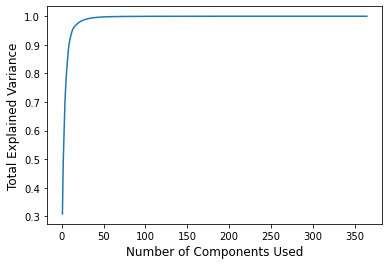

In [75]:
# plot components vs total explained variance
plt.plot(range(1, pca.n_components_+1), pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of Components Used', fontsize=12)
plt.ylabel('Total Explained Variance', fontsize=12);

<details><summary>Check: If I wanted to explain at least 80% of the variability in my data with principal components, what is the smallest number of principal components that I would need to keep? </summary>

- Only six! 
- I could keep $Z_1, Z_2, \ldots, Z_6$ in my model, and this would explain 80.8% of the variability in my $X$ data.
</details>

## Let's compare our PCA'ed performance to our original performance!

#### Original performance:

<img src="../images/lr_performance.png" alt="drawing" width="800"/>

#### Principal Component Regression performance:

In [15]:
# Instantiate PCA with 10 components.
pca = PCA(n_components = 10, random_state = 42)

# Fit PCA to training data.
pca.fit(X_train)

PCA(n_components=10, random_state=42)

In [16]:
# Instantiate linear regression model.
lm = LinearRegression()

# Transform Z_train and Z_test.
Z_train = pca.transform(X_train)
Z_test = pca.transform(X_test)

# Fit on Z_train.
lm.fit(Z_train, y_train)

# Score on training and testing sets.
print(f'Training Score: {round(lm.score(Z_train, y_train),4)}')
print(f'Testing Score: {round(lm.score(Z_test, y_test),4)}')

Training Score: 0.2902
Testing Score: 0.2639


In [28]:
# How the original values are transformed using the components
X_train @ pca.components_.T

array([[12.94862714, -3.25895475, -0.83258097, ...,  0.21061332,
        -1.04438452,  4.58873807],
       [ 2.65671983, -5.13317379,  1.32197723, ...,  1.32333209,
        -0.3269294 ,  0.67175592],
       [-0.99022044, -3.64070419, -4.84516339, ...,  3.24618057,
         5.4544525 ,  1.44288792],
       ...,
       [11.99105505,  4.26477928,  7.33440283, ...,  0.56573233,
         3.10423591,  3.97569048],
       [13.43951764,  0.71829829, -4.22228971, ..., -1.02455337,
        -3.19519537,  0.44731917],
       [-9.97847424,  0.56678693, 11.27847261, ..., -2.69871193,
        -1.75625064,  2.90491697]])

Our final model here is:

$$
\begin{eqnarray*}
[\text{quality}] &=& \beta_0 + \beta_1Z_1 + \beta_2Z_2 + \cdots + \beta_{10}Z_{10} \\
\\
\text{where } Z_1 &=& \gamma_1X_1 + \gamma_2X_2 + \gamma_3X_3 + \cdots \gamma_pX_p \\
\text{and } Z_2 &=& \delta_1X_1 + \delta_2X_2 + \delta_3X_3 + \cdots \delta_pX_p \\
&\vdots& \\
\text{and } Z_{10} &=& \eta_1X_1 + \eta_2X_2 + \eta_3X_3 + \cdots \eta_pX_p \\
\end{eqnarray*}
$$

In [17]:
# Make a PCA dataframe
columns = [f'PCA_{i+1}' for i in pd.DataFrame(Z_train).columns]
z_df = pd.DataFrame(data = Z_train, columns=columns)
z_df['Wine_Quality'] = y_train.values
z_df.head()

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,Wine_Quality
0,12.948627,-3.258955,-0.832581,-2.804569,4.013368,2.543780,-7.019037,0.210613,-1.044385,4.588738,5
1,2.656720,-5.133174,1.321977,7.870713,7.259017,1.834894,-4.380642,1.323332,-0.326929,0.671756,6
2,-0.990220,-3.640704,-4.845163,-1.805145,-4.065424,-7.852356,3.627241,3.246181,5.454453,1.442888,6
3,-4.978165,37.883902,-1.540496,-18.391432,-18.798863,39.651140,19.141686,-18.185576,0.848820,-16.846519,6
4,-1.351178,-8.745763,-0.088128,-6.097010,2.148219,1.394471,-1.591332,2.148140,1.898963,1.393446,6


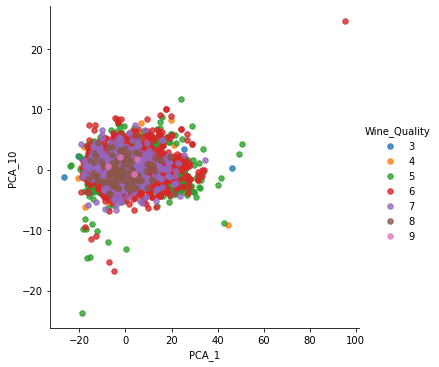

In [32]:
# Visualize PCA_1 vs. PCA_10
sns.lmplot(
    x="PCA_1",
    y="PCA_10",
    data=z_df, 
    fit_reg=False, 
    hue='Wine_Quality', # color by cluster
    legend=True,   
    scatter_kws={"s": 30} # specify the point size
); 

**Two assumptions that PCA makes:**
1. **Linearity:** PCA detects and controls for linear relationships, so we assume that the data does not hold nonlinear relationships (or that we don't care about these nonlinear relationships).
    - We are using our covariance matrix to determine important "directions," which is a measure of the linear relationship between observations!
    - There are other types of feature extraction like [t-SNE](https://lvdmaaten.github.io/tsne/) and [PPA](https://towardsdatascience.com/interesting-projections-where-pca-fails-fe64ddca73e6), though we won't formally cover those in a global lesson.
    
    
2. **Large variances define importance:** If data is spread in a direction, that direction is important! If there is little spread in a direction, that direction is not very important.
    - That aligns with what we saw [here](http://setosa.io/ev/principal-component-analysis/).

### Potential Use Cases for PCA
- Situations where $p \not\ll n$. (Situations where $p$ is not substantially smaller than $n$.)
- Situations in which there are variables with high multicollinearity. (Can be traditional models or models with highly correlated inputs by design, like images.)
- Situations in which there are many variables, even without explicit multicollinearity.

### Interview Questions

<details><summary>Explain PCA to me.</summary>

- Principal component analysis is a method of dimensionality reduction that **identifies important relationships** in our data, **transforms the existing data** based on these relationships, and then **quantifies the importance** of these relationships so we can keep the most important relationships and drop the others!

<details><summary>How can I remember the above?</summary>

Matt's "Three Signposts:"
- Covariance Matrix
- Eigenvectors
- Eigenvalues
</details>
</details>

<details><summary>In what cases would I not use PCA?</summary>

- Since PCA distorts the interpretability of our features, we should not use PCA if our goal is to interpret the output of our model.
- If we have relatively few features as inputs, PCA is unlikely to have a large positive impact on our model.
</details>